In [1]:
import numpy as np
import os
import pickle
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def load_jets(root_dir, filename):
    """Load truth binary trees"""
    #root_dir = "../data/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [3]:
lambda_truth = 1.5
pt_cut_truth = 9.0

n_lambda = 150
N_jets = 10000

#lambda_min = 1.6
#lambda_max = 2.75

lambda_min = 1.0
lambda_max = 2.5

lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)

Njets = 20000

In [4]:
truth_bin = None
        
for ix, x in enumerate(lambda_vals >= lambda_truth):
    if x.item() is True:
        truth_bin = ix-1
        break
truth_bin

49

In [5]:
gt_trees = load_jets("data", "ginkgo_{}_jets_no_cuts_lambda_{}_pt_min_{}_jetp_400_with_perm_sym".format(Njets,
                                                                                                    int(lambda_truth*10),
                                                                                                    int(pt_cut_truth)))  # My test file

In [6]:
truth_num_leaves = np.array([len(x["leaves"]) for x in gt_trees])
truth_num_leaves_sigma = np.sqrt(np.histogram(truth_num_leaves, bins=np.arange(1,16)-0.5)[0]) / truth_num_leaves.size

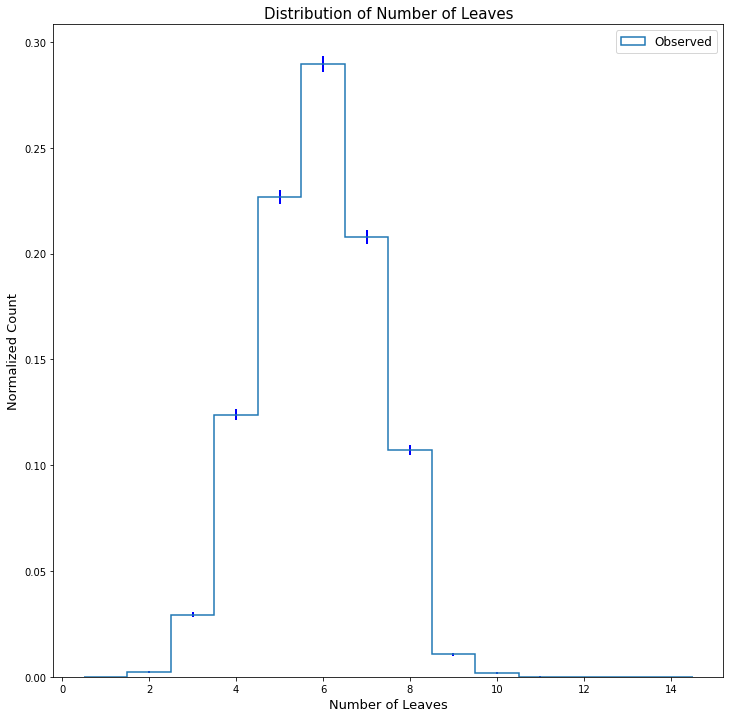

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12,12)

truth_hist = ax.hist(truth_num_leaves, bins=np.arange(1,16)-0.5, histtype="step", linewidth=1.5, density=True, label="Observed")
for i in range(14):
    ax.vlines(i+1,
              ymin=truth_hist[0][i] - truth_num_leaves_sigma[i],
              ymax=truth_hist[0][i] + truth_num_leaves_sigma[i],
              colors="blue", linestyle="solid", linewidth=2)

ax.set_xlabel("Number of Leaves", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Number of Leaves", size=15)
ax.legend(fontsize="large")

In [8]:
def get_likelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                 Njets=10000,
                                 pt_cut=30.0,
                                 likelihood="marginal",
                                 datadir="/scratch/mdd424/data/trellis"):
    
    if likelihood.lower() == "marginal":
        key = "Z"
    elif likelihood.lower() == "map":
        key = "trellis_MLE"
    else:
        return None
    
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
        
    likelihood_surface = np.zeros((Njets, n_lambda))
    
    for i in range(n_lambda):
        model_params = {"delta_min": pt_cut, "lam": lambda_vals[i]}

        in_filename = os.path.join(datadir, "trellis_{}_jets_1D_lambda_{:n}_ptcut_{:n}_{}_with_perm_sym.pkl".format(
            Njets,
            int(lambda_vals[i])*1000,
            int(pt_cut),
            i))
        with open(in_filename, "rb") as fd:
            results = pickle.load(fd, encoding='latin-1')

        for k in range(Njets):
            likelihood_surface[k,i] = results[key][k]
                
    return likelihood_surface

In [9]:
Njets = 20000

likelihood_surface_array = get_likelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                                        Njets=Njets,
                                                        pt_cut=pt_cut_truth,
                                                        likelihood="marginal")

In [10]:
bad_indices = []
for ix, entry in enumerate(likelihood_surface_array):
    if np.isnan(entry).sum() == n_lambda:
        bad_indices.append(ix)
bad_indices = np.array(bad_indices)
        
good_indices = np.arange(likelihood_surface_array.shape[0])
for bad_ix in bad_indices:
    good_indices = good_indices[good_indices != bad_ix]

In [11]:
likelihood_surface_array = likelihood_surface_array[good_indices]
gt_trees = (np.array(gt_trees)[good_indices]).tolist()

In [12]:
total_likelihood_surface = np.sum(likelihood_surface_array, axis=0)

In [13]:
mle_coords = np.unravel_index(np.argmax(total_likelihood_surface[~np.isnan(total_likelihood_surface)], axis=None),
                                  total_likelihood_surface.shape)[0]
mle_coords

0

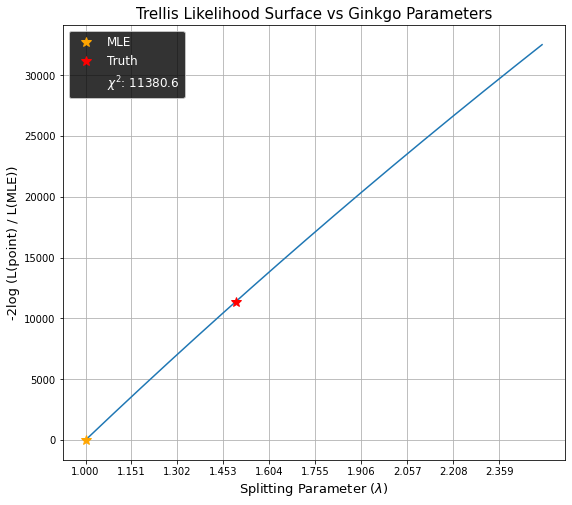

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(total_likelihood_surface-total_likelihood_surface.max())

chi2_marginal = Z[truth_bin]

ax.plot(lambda_vals, Z)
ax.plot(lambda_vals[mle_coords], Z[mle_coords], '*', color="orange", label="MLE", markersize=10)
#for coords in batch_mle_coords:
#    ax.plot(lambda_vals[coords], Z[coords], "*", color="orange", markersize=9)
ax.plot(lambda_vals[truth_bin], Z[truth_bin], '*', label="Truth", markersize=10, color="red")
ax.plot([], [], ' ', label="$\chi^2$: {:.1f}".format(chi2_marginal))


ax.legend(labelcolor="white", facecolor="black", fontsize="large")
ax.grid()

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("-2log (L(point) / L(MLE))", size=13)
ax.set_xticks(lambda_vals[::15]);